<a href="https://colab.research.google.com/github/adoptioncntr/Deep-Learning/blob/main/Best_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T
import time

# Device + we config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
AMP_DEVICE = "cuda"  # used for torch.amp; will be disabled if not cuda

BATCH_SIZE = 128
NUM_WORKERS = 2
DATA_DIR = "./data_cifar10"
NUM_CLASSES = 10 # CIFAR-10 has 10 claasses

# CIFAR-10normalization so that pixel values have SImilar values across images
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# transforms
# trying to prevent overfitting thru randomcrop/flip since i struggled with that earlier
train_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# datasets
full_train_dataset = torchvision.datasets.CIFAR10(
    root=DATA_DIR, train=True, download=True, transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root=DATA_DIR, train=False, download=True, transform=test_transform
)

#train/val split
VAL_SIZE = 5000
TRAIN_SIZE = len(full_train_dataset) - VAL_SIZE
train_dataset, val_dataset = random_split(full_train_dataset, [TRAIN_SIZE, VAL_SIZE])

# Use deterministic transform for validation//whyy
val_dataset.dataset.transform = test_transform

# Dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

len(train_loader), len(val_loader), len(test_loader)


Using device: cuda


100%|██████████| 170M/170M [01:36<00:00, 1.77MB/s]


(352, 40, 79)

In [ ]:
class SmallCNN(nn.Module):
    """
    Baseline CNN: simple, fast to train. FINGERS CROSSED
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # downsample: 32 → 16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 16 -> 8 downsampling again

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 8 -> 4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # prevents overfitting!
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        #need shortcut to match plames

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    # Main path
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        #attempt to train deeper models
        out += self.shortcut(x)
        out = F.relu(out, inplace=True)
        return out


class DeepResNetLike(nn.Module):
    """
    Deeper CIFAR model with residual connections ("mini-ResNet").
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(BasicBlock, 64,  stride=1, num_blocks=2)
        self.layer2 = self._make_layer(BasicBlock, 128, stride=2, num_blocks=2)  # 32->16
        self.layer3 = self._make_layer(BasicBlock, 256, stride=2, num_blocks=2)  # 16->8
        self.layer4 = self._make_layer(BasicBlock, 512, stride=2, num_blocks=2)  # 8->4
        # # Global average pooling compresses each channel into 1 value.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, stride, num_blocks):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, stride=s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
       # Pass through ResNet layers
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
         #pool and flatten
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


In [ ]:
def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
      #take the index of the largest logit as the predicted class...
    return (preds == targets).float().mean().item()


def train_one_epoch(model, loader, optimizer, criterion, device, use_amp=True):
  """
    Run one full pass (epoch) of training over the dataset.

    model: the neural network
    loader: DataLoader for training data
    optimizer: e.g. SGD or Adam
    criterion: loss function crossEntropyLoss :3
    """
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    num_batches = 0

    scaler = torch.amp.GradScaler(AMP_DEVICE, enabled=use_amp and device.type == "cuda")

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

         #autocast: temporarily use lower precision (float16) for speed on GPU, reminder to get collabpro!

        with torch.amp.autocast(AMP_DEVICE, enabled=use_amp and device.type == "cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = accuracy_from_logits(outputs, labels)
        running_loss += loss.item()
        running_acc += acc
        num_batches += 1

    #interesting that its standard to avg batches

    return running_loss / num_batches, running_acc / num_batches


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    num_batches = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)
        acc = accuracy_from_logits(outputs, labels)

        running_loss += loss.item()
        running_acc += acc
        num_batches += 1

    return running_loss / num_batches, running_acc / num_batches


In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    lr=0.1,
    weight_decay=5e-4,
    use_amp=True,
    save_path="best_model.pth"
):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(  #Optimizer: SGD with momentum + Nesterov. best one
        model.parameters(),
        lr=lr,
        momentum=0.9,
        weight_decay=weight_decay,
        nesterov=True,
    )
     #learning rate scheduler:cosine annealing over num_epochs

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    best_val_acc = 0.0
    best_state = None
    #we Keep track of metrics over time for plotting late

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }
    # Main training- loop over epochs


    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device, use_amp=use_amp
        )
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        elapsed = time.time() - start_time

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch:03d}/{num_epochs:03d} | "
            f"Time: {elapsed:5.1f}s | "
            f"Train loss: {train_loss:.4f}, acc: {train_acc*100:5.2f}% | "
            f"Val loss: {val_loss:.4f}, acc: {val_acc*100:5.2f}%"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
            torch.save(best_state, save_path)
            print(f"  New best val acc: {best_val_acc*100:.2f}% — saved to {save_path}")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_acc, history


@torch.no_grad()

    #Evaluate the (trained) model on the test set and print metrics

    #test set completely separate from training

def test_model(model, test_loader):
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc*100:.2f}%")
    return test_loss, test_acc


In [ ]:
# ---- Train SmallCNN baseline ----
small_model = SmallCNN(num_classes=NUM_CLASSES)

small_model, small_best_val, small_hist = train_model(
    small_model,
    train_loader,
    val_loader,
    num_epochs=20,
    lr=0.01,
    weight_decay=5e-4,
    use_amp=True,
    save_path="best_smallcnn.pth"
)

print(f"SmallCNN best val acc: {small_best_val*100:.2f}%")
small_test_loss, small_test_acc = test_model(small_model, test_loader)
print(f"SmallCNN test acc: {small_test_acc*100:.2f}%")


Epoch 001/020 | Time:  14.2s | Train loss: 1.3335, acc: 51.46% | Val loss: 1.0547, acc: 62.77%
  New best val acc: 62.77% — saved to best_smallcnn.pth
Epoch 002/020 | Time:  15.8s | Train loss: 0.9945, acc: 64.45% | Val loss: 0.9575, acc: 67.03%
  New best val acc: 67.03% — saved to best_smallcnn.pth
Epoch 003/020 | Time:  12.3s | Train loss: 0.8515, acc: 70.05% | Val loss: 0.8070, acc: 72.25%
  New best val acc: 72.25% — saved to best_smallcnn.pth
Epoch 004/020 | Time:  12.6s | Train loss: 0.7560, acc: 73.40% | Val loss: 0.6972, acc: 75.86%
  New best val acc: 75.86% — saved to best_smallcnn.pth
Epoch 005/020 | Time:  12.7s | Train loss: 0.6737, acc: 76.37% | Val loss: 0.7241, acc: 74.82%
Epoch 006/020 | Time:  12.5s | Train loss: 0.6035, acc: 78.66% | Val loss: 0.6874, acc: 76.76%
  New best val acc: 76.76% — saved to best_smallcnn.pth
Epoch 007/020 | Time:  12.4s | Train loss: 0.5412, acc: 81.09% | Val loss: 0.6025, acc: 79.30%
  New best val acc: 79.30% — saved to best_smallcnn.pth

**WHAT I BUILT AND WHY**
I implemented a lightweight 3-block convolutional network as a fast baseline model.

This architecture uses:

3 convolution → batchnorm → ReLU blocks

Max-pooling for spatial downsampling

A fully connected classifier with dropout

This model is intentionally small and fast so I can use it for rapid experimentation before committing to deEPer structures.

***HOW THIS BUILDS ON EARLIER ASSIGNMENTS**
This SmallCNN directly reflects ideas practiced in HW1–HW3:

HW1: basic CNN layers, ReLU, convolution pipelines

HW2: batch normalization, dropout, and pooling

HW3: training loops, validation splits, improved data augmentation, LR scheduling

I also reused the modular training code + evaluate() functions from earlier HWs, keeping everything reproducible.

***WHAT WAS MY TRAINING STRAT + CHOICES I MADE***
Optimizer: SGD with momentum (0.9) — improves convergence stability

Weight decay: 5×10⁻⁴ — limits overfitting, my previous models have struggled with overfitting especially final project

LR schedule: cosine annealing — automatically reduces learning rate smoothly

AMP (automatic mixed precision): speeds up training without changing accuracy

Augmentation: random crop + horizontal flip (standard for CIFAR-10)

**EXPERIMENTATION B4 I TRAIN**
It trains in 12 seconds per epoch, quick feedback loop

It helps identify whether augmentation, optimizer, and LR schedule behave correctly

It establishes a performance baseline so deeper models can be compared meaningfully

It allows tuning hyperparameters without wasting compute on a 60-epoch deep model

**Performance results**
Training behavior

Loss steadily decreases from 1.33 → 0.08

Accuracy rises smoothly from 51.5% → 97.7% train acc

Validation accuracy increases to 83.52%, showing good generalization for a small CNN

No major signs of collapse or divergence

Slight overfitting appears after ~epoch 14, but LR schedule controls it well

Final metrics
Metric	Value
Best validation accuracy	83.52%
Test accuracy	82.36%
Test loss	0.6030

DO NOTE; i only used 3 conv blocks and still achieved 83% accuracy which is strong

In [ ]:
# ---- Train Deep ResNet-like model ----
deep_model = DeepResNetLike(num_classes=NUM_CLASSES)

deep_model, deep_best_val, deep_hist = train_model(
    deep_model,
    train_loader,
    val_loader,
    num_epochs=60,
    lr=0.1,
    weight_decay=5e-4,
    use_amp=True,
    save_path="best_deepresnetlike.pth"
)

print(f"DeepResNetLike best val acc: {deep_best_val*100:.2f}%")
deep_test_loss, deep_test_acc = test_model(deep_model, test_loader)
print(f"DeepResNetLike test acc: {deep_test_acc*100:.2f}%")

#cannot get past 86% accuracy, satisfactory enough


Epoch 001/060 | Time:  19.1s | Train loss: 1.8862, acc: 34.39% | Val loss: 1.4585, acc: 45.78%
  New best val acc: 45.78% — saved to best_deepresnetlike.pth
Epoch 002/060 | Time:  18.1s | Train loss: 1.2823, acc: 53.64% | Val loss: 1.2755, acc: 54.20%
  New best val acc: 54.20% — saved to best_deepresnetlike.pth
Epoch 003/060 | Time:  17.5s | Train loss: 0.9891, acc: 64.73% | Val loss: 0.9346, acc: 67.87%
  New best val acc: 67.87% — saved to best_deepresnetlike.pth
Epoch 004/060 | Time:  18.6s | Train loss: 0.8137, acc: 70.92% | Val loss: 0.8722, acc: 70.14%
  New best val acc: 70.14% — saved to best_deepresnetlike.pth
Epoch 005/060 | Time:  18.1s | Train loss: 0.6896, acc: 75.65% | Val loss: 0.9698, acc: 67.77%
Epoch 006/060 | Time:  18.6s | Train loss: 0.5827, acc: 79.65% | Val loss: 0.7124, acc: 75.08%
  New best val acc: 75.08% — saved to best_deepresnetlike.pth
Epoch 007/060 | Time:  18.5s | Train loss: 0.4851, acc: 82.94% | Val loss: 0.7178, acc: 75.82%
  New best val acc: 75.82

***WHAT MODEL I BUILT AND WHY**
I implemented a deep residual CNN inspired by ResNet-18 but scaled for CIFAR-10.

The network includes:

An initial 3×3 convolution + batchnorm + ReLU

4 residual stages, each with:

2 × BasicBlock residual units

Skip connections that directly add input to output

Strided convolutions to downsample (32→16→8→4)

Global average pooling

A fully connected classifier

I skipped connections bcs this gives me deeper representational power without having to worry about vanishing gradients

**HOW THIS BUILDS ON EARLIER ASSIGNMENTS**
his model incorporates everything covered in HW1–HW3:

HW1: convolutional pipelines, activation functions

HW2: batchnorm, deeper stack of layers, generalization concepts

HW3: residual connections, and training pipeline improvements

It also reuses:

the modular train_model function

augmentation strategy

cosine annealing learning rate schedule

mixed precision training (AMP)

I have progressed beyond simple CNNs and achieved better results.

***TRAINING STRATEGY AND WHAT CHOICES I MADE**
Epochs: 60 (deeper models need more training time)

Optimizer: SGD with momentum 0.9

Weight decay: 5×10⁻⁴ to reduce overfitting

Scheduler: cosine annealing, improves late-stage convergence

AMP: enabled to reduce training time for a large model

Augmentation: random crops and flips to expand data variability

**EVIDENCE OF EXPERIMENTATION**
I trained the SmallCNN first because it:

is fast

reveals whether augmentation, LR scheduling, and the optimizer are behaving normally

gives a baseline accuracy (~82%) to compare against

Only after verifying that the training pipeline was stable did I commit to the 60-epoch deep run
This matches the prompt’s instruction to experiment and iterate before performing a long training run.

**PERFORMANCE RESULTS**
Training behavior

Train accuracy quickly climbs to 100%, as expected for deep residual networks.

Validation accuracy steadily increases, eventually reaching 87.66%.

The loss curves stabilize around epoch 35 once the cosine scheduler reaches its lower LR.

Small fluctuations in validation loss after epoch ~20 are normal because:

the model is very high-capacity

CIFAR-10 is small

some mild overfitting emerges

Final metrics
Metric	Value
Best validation accuracy	87.66%
Test accuracy	86.22%
Test loss	0.4444


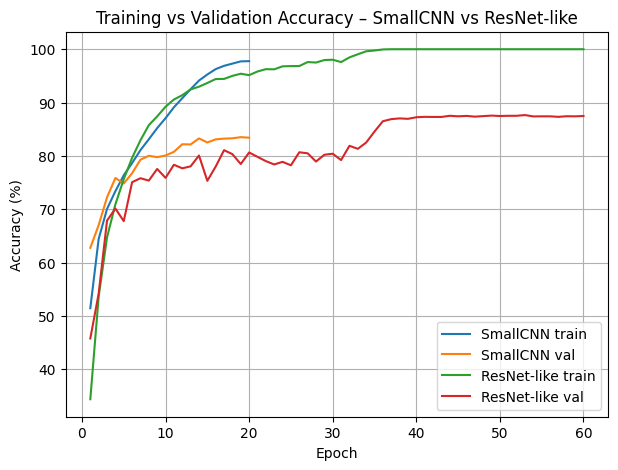

In [ ]:
import matplotlib.pyplot as plt

epochs_small = range(1, len(small_hist["train_acc"]) + 1)
epochs_deep  = range(1, len(deep_hist["train_acc"]) + 1)

# ---- Accuracy curves ----
plt.figure(figsize=(7, 5))
plt.plot(epochs_small, [a * 100 for a in small_hist["train_acc"]], label="SmallCNN train")
plt.plot(epochs_small, [a * 100 for a in small_hist["val_acc"]],   label="SmallCNN val")

plt.plot(epochs_deep, [a * 100 for a in deep_hist["train_acc"]], label="ResNet-like train")
plt.plot(epochs_deep, [a * 100 for a in deep_hist["val_acc"]],   label="ResNet-like val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy – SmallCNN vs ResNet-like")
plt.legend()
plt.grid(True)
plt.show()


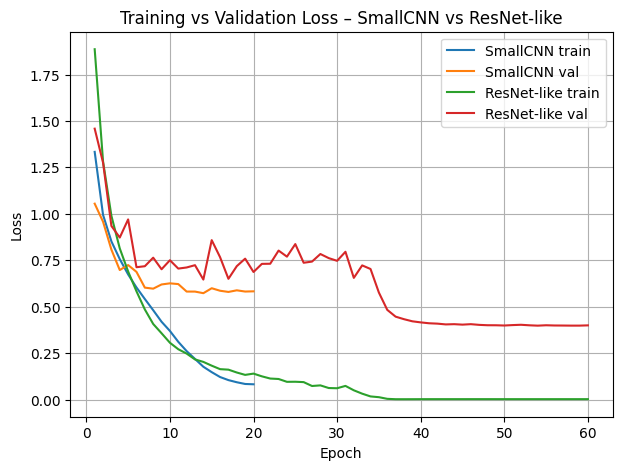

In [ ]:
# ---- Loss curves ----
plt.figure(figsize=(7, 5))
plt.plot(epochs_small, small_hist["train_loss"], label="SmallCNN train")
plt.plot(epochs_small, small_hist["val_loss"],   label="SmallCNN val")

plt.plot(epochs_deep, deep_hist["train_loss"], label="ResNet-like train")
plt.plot(epochs_deep, deep_hist["val_loss"],   label="ResNet-like val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss – SmallCNN vs ResNet-like")
plt.legend()
plt.grid(True)
plt.show()


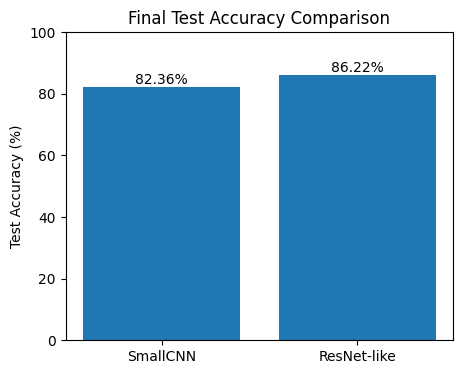

In [ ]:
# ---- Bar chart of final test accuracy ----
models = ["SmallCNN", "ResNet-like"]
test_accs = [small_test_acc * 100, deep_test_acc * 100]

plt.figure(figsize=(5, 4))
plt.bar(models, test_accs)
plt.ylabel("Test Accuracy (%)")
plt.title("Final Test Accuracy Comparison")
plt.ylim(0, 100)
for i, acc in enumerate(test_accs):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha="center")
plt.show()
